# Tarea 1: Extracción de descriptores de una imágen


## Instrucciones de uso
1. Asegúrate de tener la imagen **sopa_letras.png** en el mismo directorio del notebook o en la ruta '/content/sopa_letras.png'.  
2. El programa cargará la imagen, segmentará cada letra y calculará los siguientes descriptores por letra:  
   - 4 primeros momentos de Hu  
   - Perímetro  
   - Redondez  
   - Ángulo de orientación de la elipse  

Al finalizar, se mostrarán dos resultados:  

- La **figura** con los centros de masa de cada letra marcados en rojo.  
- Un **DataFrame** impreso en pantalla con todos los descriptores.  

    Letter       Hu1       Hu2       Hu3       Hu4   Perimeter  Roundness  \
0        1  0.425378  0.025908  0.013871  0.000732  226.350286   0.297270   
1        2  0.337127  0.003917  0.000911  0.000407  206.710677   0.285858   
2        3  0.363250  0.011855  0.002181  0.000449  251.705625   0.260627   
3        4  0.257982  0.001658  0.000276  0.000161  129.195958   0.351584   
4        5  0.364220  0.032158  0.001117  0.000161  188.710677   0.261831   
5        6  0.292098  0.010319  0.002518  0.000852   67.112698   0.365487   
6        7  0.533992  0.213339  0.025221  0.008095  215.178713   0.203008   
7        8  0.354090  0.010660  0.002156  0.000553  150.325901   0.270814   
8        9  0.535181  0.213728  0.025933  0.008523  153.580734   0.204049   
9       10  0.292864  0.012324  0.004910  0.000336   88.911687   0.449861   
10      11  0.230027  0.000899  0.000148  0.000066   81.455844   0.409090   
11      12  0.292098  0.010319  0.002518  0.000852   67.112698   0.365487   

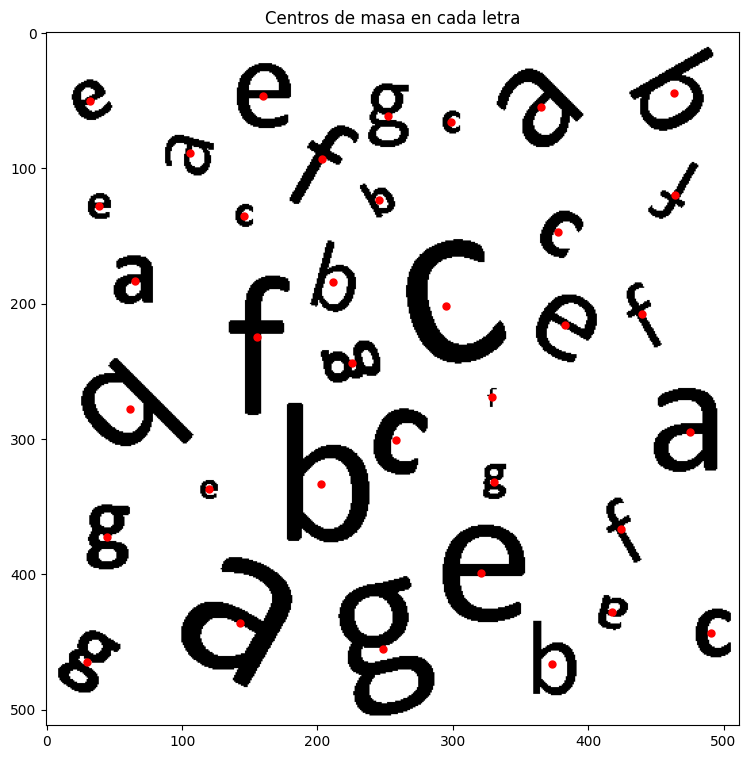

In [10]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2


def perimeter_opencv(region):
    """
    Calcula el perímetro usando cv2.arcLength
    """
    mask = (region.image.astype("uint8"))
    cnts, hc = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnt = cnts[0]  # primer contorno (el externo si RETR_EXTERNAL)
    return cv2.arcLength(cnt, True), cnt


def perimeter_manual(region):
    """
    Calcula el perímetro sumando distancias euclidianas entre puntos del contorno
    """
    mask = (region.image.astype("uint8"))
    cnts, hc = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnt = cnts[0]
    pts = cnt.reshape(-1, 2).astype(np.float64)  # (N, 2)

    perimetro = 0.0
    for i in range(len(pts) - 1):
        dx = pts[i+1, 0] - pts[i, 0]
        dy = pts[i+1, 1] - pts[i, 1]
        perimetro += np.sqrt(dx**2 + dy**2)

    # Matriz circular
    dx = pts[0, 0] - pts[-1, 0]
    dy = pts[0, 1] - pts[-1, 1]
    perimetro += np.sqrt(dx**2 + dy**2)

    return perimetro

if __name__=='__main__':


  im = cv2.imread("/content/sopa_letras.png")

  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  ret,bw = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV) # Binarizacion

  etiquetas = label(bw)
  sts = regionprops(label_image=etiquetas)

  data = []
  centers = []
  for region in sts:

      hu = np.round(region.moments_hu[:4],6)   # solo primeros 4 momentos
      A = region.area
      L,_ = perimeter_opencv(region)
      roundness = (4 * np.pi * A) / (L**2)
      y, x = region.centroid #(row, col)
      centers.append((x, y))

      data.append({
          "Letter": region.label,
          "Hu1": hu[0],
          "Hu2": hu[1],
          "Hu3": hu[2],
          "Hu4": hu[3],
          "Perimeter": L, #el resultado es el mismo mediante la forma manual y el metodo de openCV
          "Roundness": roundness, # Calculo manual a partir del area y perimetro
          "Orientation": np.rad2deg(region.orientation) # Orientacion de la elipse en grados [-90°,90°]
      })

  df = pd.DataFrame(data)
  print(df)

  plt.figure(figsize=(9,9))
  plt.imshow(gray, cmap='gray')
  j = [c[0] for c in centers]
  i = [c[1] for c in centers]
  plt.plot(j, i, 'ro', markersize=5)
  plt.title('Centros de masa en cada letra')
  plt.show()



